In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from collections import OrderedDict

/tmp/ipykernel_18004/1341984599.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
plt.rcParams["figure.figsize"] = (20,10)

def plot_stacked_region(base_path, sampling_base, sampling_ids_list):

    region_counts = {
        "easy": [],
        "ambiguous": [],
        "hard": [],
    }

    x_axis = []

    df = pd.read_pickle(base_path+"datamap_metrics.pkl")

    for sampled_question_ids_path in sampling_ids_list:
        split_path = sampled_question_ids_path.split('/')
        if 'beta_kernel' in sampled_question_ids_path:
            sampling_name = split_path[2] + '_' + split_path[-1][:-14]
        elif 'beta_pvals' in sampled_question_ids_path or 'beta_var_counts' in sampled_question_ids_path:
            sampling_name = split_path[1] + '_' + split_path[-1][:-14]
        elif 'global' in sampled_question_ids_path:
            sampling_name = split_path[0]
        else:
            sampling_name = 'classwise_' + split_path[0]
        x_axis.append(sampling_name)
        #x_axis.append(sampled_question_ids_path)
        
        with open(sampling_base + sampled_question_ids_path, 'rb') as f:
            sampled_ids = pickle.load(f)

        df_sampled = df.loc[df['question_id'].isin(sampled_ids)]

        df_easy = df_sampled.loc[(df_sampled['confidence'] > 0.6) & (df_sampled['variability'] < 0.15)]
        df_hard = df_sampled.loc[(df_sampled['confidence'] < 0.4) & (df_sampled['variability'] < 0.2)]
        df_ambiguous = df_sampled.loc[df_sampled['variability'] > 0.3]

        region_counts['easy'].append(len(df_easy))
        region_counts['hard'].append(len(df_hard))
        region_counts['ambiguous'].append(len(df_ambiguous))



    fig, ax = plt.subplots()
    bottom = np.zeros(37)
    width = 0.5
    for boolean, weight_count in region_counts.items():
        p = ax.bar(x_axis, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count

    ax.set_title("Datamap Region Frequency Across Selection Methods")
    ax.legend(loc="upper right")
    plt.xticks(fontsize=10, rotation=90)


    plt.show()

    #return region_counts, x_axis


def plot_stacked_variability(base_path, sampling_base, sampling_ids_list, accuracies):

    region_counts = {
        "0-0.1": [],
        "0.1-0.2": [],
        "0.2-0.3": [],
        "0.3-0.4": [],
        "0.4-0.5": [],
    }

    x_axis = []

    df = pd.read_pickle(base_path+"datamap_metrics.pkl")

    for sampled_question_ids_path in sampling_ids_list:
        split_path = sampled_question_ids_path.split('/')
        if 'beta_kernel' in sampled_question_ids_path:
            sampling_name = split_path[2] + '_' + split_path[-1][:-14]
        elif 'beta_pvals' in sampled_question_ids_path or 'beta_var_counts' in sampled_question_ids_path:
            sampling_name = split_path[1] + '_' + split_path[-1][:-14]
        elif 'global' in sampled_question_ids_path:
            sampling_name = split_path[0]
        else:
            sampling_name = 'classwise_' + split_path[0]
        #x_axis.append(sampling_name)
        x_axis.append(sampled_question_ids_path)
        
        with open(sampling_base+ sampled_question_ids_path, 'rb') as f:
            sampled_ids = pickle.load(f)

        df_copy = df.copy()
        df_one_orig = df_copy.loc[(df_copy['variability'] > 0.0) & (df_copy['variability'] <= 0.1)]
        df_two_orig = df_copy.loc[(df_copy['variability'] > 0.1) & (df_copy['variability'] <= 0.2)]
        df_three_orig = df_copy.loc[(df_copy['variability'] > 0.2) & (df_copy['variability'] <= 0.3)]
        df_four_orig = df_copy.loc[(df_copy['variability'] > 0.3) & (df_copy['variability'] <= 0.4)]
        df_five_orig = df_copy.loc[(df_copy['variability'] > 0.4) & (df_copy['variability'] <= 0.5)]

        df_sampled = df.loc[df['question_id'].isin(sampled_ids)]
        df_one = df_sampled.loc[(df_sampled['variability'] > 0.0) & (df_sampled['variability'] <= 0.1)]
        df_two = df_sampled.loc[(df_sampled['variability'] > 0.1) & (df_sampled['variability'] <= 0.2)]
        df_three = df_sampled.loc[(df_sampled['variability'] > 0.2) & (df_sampled['variability'] <= 0.3)]
        df_four = df_sampled.loc[(df_sampled['variability'] > 0.3) & (df_sampled['variability'] <= 0.4)]
        df_five = df_sampled.loc[(df_sampled['variability'] > 0.4) & (df_sampled['variability'] <= 0.5)]

        region_counts['0-0.1'].append(len(df_one))
        region_counts['0.1-0.2'].append(len(df_two))
        region_counts['0.2-0.3'].append(len(df_three))
        region_counts['0.3-0.4'].append(len(df_four))
        region_counts['0.4-0.5'].append(len(df_five))

        print("Path: ", sampled_question_ids_path)
        print('0-0.1: ', len(df_one) / len(df_one_orig))
        print('0.1-0.2: ', len(df_two) / len(df_two_orig))
        print('0.2-0.3: ', len(df_three) / len(df_three_orig))
        print('0.3-0.4: ', len(df_four) / len(df_four_orig))
        print('0.4-0.5: ', len(df_five) / len(df_five_orig))

    # y = region_counts['0-0.1'].copy()
    # region_counts['0.3-0.4'] = [x for _,x in sorted(zip(y,region_counts['0.3-0.4']))]
    # region_counts['0.2-0.3'] = [x for _,x in sorted(zip(y,region_counts['0.2-0.3']))]
    # region_counts['0.1-0.2'] = [x for _,x in sorted(zip(y,region_counts['0.1-0.2']))]
    # region_counts['0.4-0.5'] = [x for _,x in sorted(zip(y,region_counts['0.4-0.5']))]
    # region_counts['0-0.1'] = sorted(region_counts['0-0.1'])

    # print(region_counts)

    region_counts_sorted = {
        "0-0.1": [],
        "0.1-0.2": [],
        "0.2-0.3": [],
        "0.3-0.4": [],
        "0.4-0.5": [],
    }
    y = np.argsort(region_counts['0-0.1'])

    region_counts_sorted['0.3-0.4'] = [region_counts['0.3-0.4'][i] for i in y]
    region_counts_sorted['0.2-0.3'] = [region_counts['0.2-0.3'][i] for i in y]
    region_counts_sorted['0.1-0.2'] = [region_counts['0.1-0.2'][i] for i in y]
    region_counts_sorted['0-0.1'] = [region_counts['0-0.1'][i] for i in y]
    region_counts_sorted['0.4-0.5'] = [region_counts['0.4-0.5'][i] for i in y]
    x_axis_sorted = [x_axis[i] for i in y]
    accuracies_sorted= [accuracies[i] for i in y]

    fig, ax = plt.subplots()
    bottom = np.zeros(len(sampling_ids_list))
    width = 0.5
    for boolean, weight_count in region_counts_sorted.items():
        #p = ax.bar(x_axis, weight_count, width, label=boolean, bottom=bottom)
        p = ax.barh(x_axis_sorted, weight_count, label=boolean, left=bottom)
        bottom += weight_count
        if boolean == '0.4-0.5':
            ax.bar_label(p, labels=list(accuracies_sorted))

    ax.set_title("Datamap Variability Bins Across Selection Methods")
    ax.legend(loc="upper left")
    plt.xticks(fontsize=10, rotation=90)


    plt.show()

    #return region_counts, x_axis

def plot_stacked_confidence(base_path, sampling_base, sampling_ids_list, accuracies):

    region_counts = {
        "0-0.2": [],
        "0.2-0.4": [],
        "0.4-0.6": [],
        "0.6-0.8": [],
        "0.8-1.0": [],
    }

    x_axis = []

    df = pd.read_pickle(base_path+"datamap_metrics.pkl")

    for sampled_question_ids_path in sampling_ids_list:
        split_path = sampled_question_ids_path.split('/')
        if 'beta_kernel' in sampled_question_ids_path:
            sampling_name = split_path[2] + '_' + split_path[-1][:-14]
        elif 'beta_pvals' in sampled_question_ids_path or 'beta_var_counts' in sampled_question_ids_path:
            sampling_name = split_path[1] + '_' + split_path[-1][:-14]
        elif 'global' in sampled_question_ids_path:
            sampling_name = split_path[0]
        else:
            sampling_name = 'classwise_' + split_path[0]
        #x_axis.append(sampling_name)
        x_axis.append(sampled_question_ids_path)
        
        with open(sampling_base + sampled_question_ids_path, 'rb') as f:
            sampled_ids = pickle.load(f)
        df_copy = df.copy()
        df_one_orig = df_copy.loc[(df_copy['confidence'] > 0.0) & (df_copy['confidence'] <= 0.2)]
        df_two_orig = df_copy.loc[(df_copy['confidence'] > 0.2) & (df_copy['confidence'] <= 0.4)]
        df_three_orig = df_copy.loc[(df_copy['confidence'] > 0.4) & (df_copy['confidence'] <= 0.6)]
        df_four_orig = df_copy.loc[(df_copy['confidence'] > 0.6) & (df_copy['confidence'] <= 0.8)]
        df_five_orig = df_copy.loc[(df_copy['confidence'] > 0.8) & (df_copy['confidence'] <= 1.0)]


        df_sampled = df.loc[df['question_id'].isin(sampled_ids)]

        df_one = df_sampled.loc[(df_sampled['confidence'] > 0.0) & (df_sampled['confidence'] <= 0.2)]
        df_two = df_sampled.loc[(df_sampled['confidence'] > 0.2) & (df_sampled['confidence'] <= 0.4)]
        df_three = df_sampled.loc[(df_sampled['confidence'] > 0.4) & (df_sampled['confidence'] <= 0.6)]
        df_four = df_sampled.loc[(df_sampled['confidence'] > 0.6) & (df_sampled['confidence'] <= 0.8)]
        df_five = df_sampled.loc[(df_sampled['confidence'] > 0.8) & (df_sampled['confidence'] <= 1.0)]

        region_counts['0-0.2'].append(len(df_one))
        region_counts['0.2-0.4'].append(len(df_two))
        region_counts['0.4-0.6'].append(len(df_three))
        region_counts['0.6-0.8'].append(len(df_four))
        region_counts['0.8-1.0'].append(len(df_five))

        print("Path: ", sampled_question_ids_path)
        print('0-0.2: ', len(df_one) / len(df_one_orig))
        print('0.2-0.4: ', len(df_two) / len(df_two_orig))
        print('0.4-0.6: ', len(df_three) / len(df_three_orig))
        print('0.6-0.8: ', len(df_four) / len(df_four_orig))
        print('0.8-1.0: ', len(df_five) / len(df_five_orig))

    region_counts_sorted = {
        "0-0.2": [],
        "0.2-0.4": [],
        "0.4-0.6": [],
        "0.6-0.8": [],
        "0.8-1.0": [],
    }
    y = np.argsort(region_counts['0.8-1.0'])

    region_counts_sorted['0.6-0.8'] = [region_counts['0.6-0.8'][i] for i in y]
    region_counts_sorted['0.4-0.6'] = [region_counts['0.4-0.6'][i] for i in y]
    region_counts_sorted['0.2-0.4'] = [region_counts['0.2-0.4'][i] for i in y]
    region_counts_sorted['0-0.2'] = [region_counts['0-0.2'][i] for i in y]
    region_counts_sorted['0.8-1.0'] = [region_counts['0.8-1.0'][i] for i in y]
    print(x_axis)
    x_axis_sorted = [x_axis[i] for i in y]
    accuracies_sorted= [accuracies[i] for i in y]
    print(x_axis_sorted)

    # y = region_counts['0.8-1.0'].copy()
    # region_counts['0.6-0.8'] = [x for _,x in sorted(zip(y,region_counts['0.6-0.8']))]
    # region_counts['0.4-0.6'] = [x for _,x in sorted(zip(y,region_counts['0.4-0.6']))]
    # region_counts['0.2-0.4'] = [x for _,x in sorted(zip(y,region_counts['0.2-0.4']))]
    # region_counts['0-0.2'] = [x for _,x in sorted(zip(y,region_counts['0-0.2']))]
    # region_counts['0.8-1.0'] = sorted(region_counts['0.8-1.0'])
    
    # print(region_counts)

    fig, ax = plt.subplots()
    bottom = np.zeros(len(sampling_ids_list))
    width = 0.5
    for boolean, weight_count in region_counts_sorted.items():
        #p = ax.bar(x_axis, weight_count, width, label=boolean, bottom=bottom)
        p = ax.barh(x_axis_sorted, weight_count, label=boolean, left=bottom)
        bottom += weight_count
        if boolean == '0.8-1.0':
            ax.bar_label(p, labels=list(accuracies_sorted))

    ax.set_title("Datamap Confidence Bins Across Selection Methods")
    ax.legend(loc="upper left")
    plt.xticks(fontsize=10, rotation=90)


    plt.show()
    #return region_counts, x_axis




base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
sampling_base = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/'
sampling_ids_list = ['beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl',
                    'beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl',
                    'beta/beta_kernel/tophat/seed_965/alpha_1_beta_1_budget_30.pkl',
                    'beta/beta_kernel/tophat/seed_965/alpha_1_beta_2_budget_30.pkl',
                    'beta/beta_kernel/tophat/seed_965/alpha_2_beta_8_budget_30.pkl',
                    'beta/beta_kernel/tophat/seed_965/alpha_8_beta_2_budget_30.pkl',
                    'beta/beta_pvals/seed_965/alpha_1_beta_1_budget_30.pkl',
                    'global_random/seed_965/budget_30.pkl',
                    'global_max_confidence/seed_965/budget_30.pkl',
                    'global_min_confidence/seed_965/budget_30.pkl',
                    'global_max_variability/seed_965/budget_30.pkl',
                    'global_min_variability/seed_965/budget_30.pkl',
                    'max_confidence/seed_965/budget_32.pkl',
                    'max_variability/seed_965/budget_32.pkl',
                    'min_confidence/seed_965/budget_32variant3.pkl',
                    'beta/var_stratified/seed_965/alpha_2_beta_8_budget_32.pkl',
                    'beta/var_stratified/seed_965/alpha_8_beta_2_budget_32.pkl',
                    'beta/beta_pvals/seed_965/alpha_2_beta_1_budget_30.pkl',
                    'beta/beta_pvals/seed_965/alpha_2_beta_2_budget_30.pkl',
                    'beta/beta_pvals/seed_965/alpha_1_beta_1_budget_30.pkl',
                    'beta/beta_pvals/seed_965/alpha_1_beta_2_budget_30.pkl'
                                            
]
# sampling_ids_list = ['beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/cosine/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/cosine/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/cosine/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/cosine/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/epanechnikov/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/epanechnikov/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/epanechnikov/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/epanechnikov/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/exponential/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/exponential/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/exponential/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/exponential/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/gaussian/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/gaussian/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/gaussian/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/gaussian/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/linear/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/linear/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/linear/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/linear/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_pvals/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_pvals/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_pvals/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_pvals/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'beta/beta_var_counts/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_var_counts/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_var_counts/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_var_counts/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'global_max_confidence/seed_965/budget_30.pkl',
#                 'global_max_variability/seed_965/budget_30.pkl',
#                 'global_min_variability/seed_965/budget_30.pkl',
#                 'global_random/seed_965/budget_30.pkl',
#                 'max_confidence/seed_965/budget_30.pkl',
# ]
# sampling_ids_list = ['beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_1_beta_1_budget_30.pkl',
#                 'beta/beta_kernel/tophat/seed_965/alpha_1_beta_2_budget_30.pkl',
#                 'global_max_confidence/seed_965/budget_30.pkl',
#                 'global_max_variability/seed_965/budget_30.pkl',
#                 'global_min_variability/seed_965/budget_30.pkl',
#                 'global_random/seed_965/budget_30.pkl',
#                 'max_confidence/seed_965/budget_30.pkl',
# ]

# sampling_ids_list = ['max_confidence/seed_965/budget_32.pkl',
#                     'max_confidence/seed_965/budget_32variant2.pkl',
#                     'max_confidence/seed_965/budget_32variant3.pkl',
#                     'max_confidence/seed_965/budget_30variant4.pkl',
# ]
#                'global_min_confidence/seed_965/budget_30.pkl',
                # 'max_variability/seed_965/budget_30.pkl',
                # 'min_confidence/seed_965/budget_30.pkl',
                # 'min_variability/seed_965/budget_30.pkl',
                # 'random/seed_965/budget_30.pkl'

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


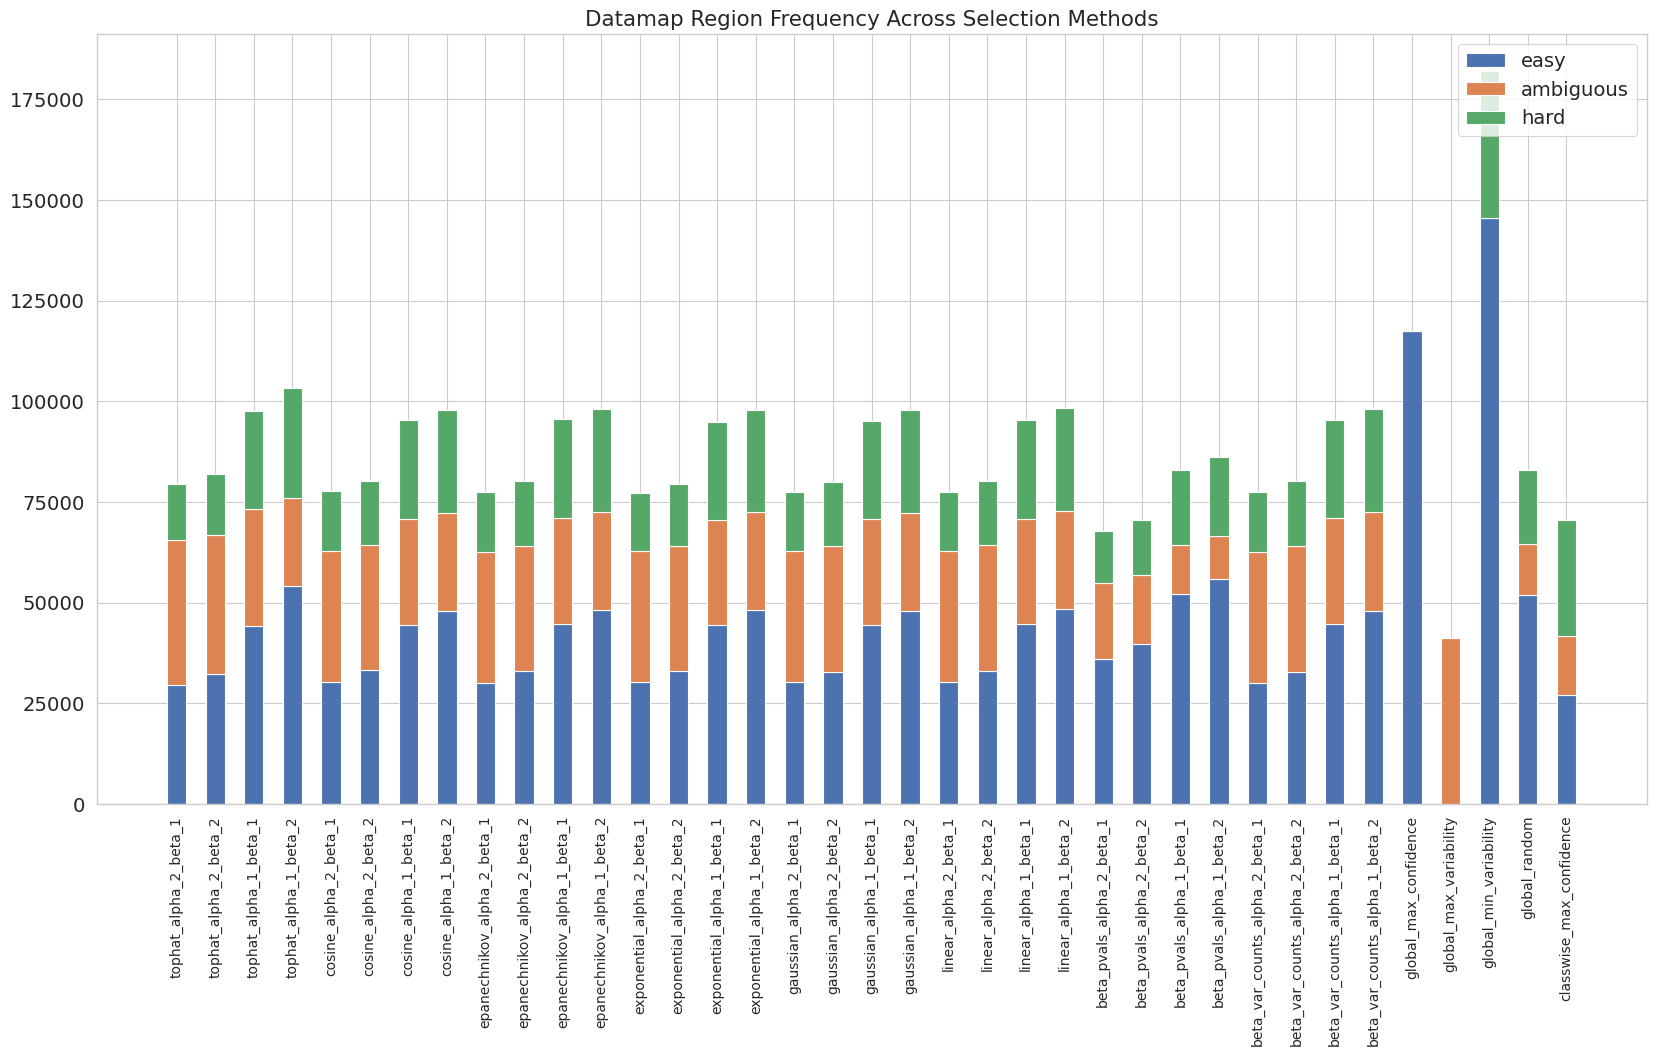

In [3]:
plot_stacked_region(base_path, sampling_base, sampling_ids_list)



Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl
0-0.2:  0.25703301943020623
0.2-0.4:  0.3233665559246955
0.4-0.6:  0.46839267229965575
0.6-0.8:  0.4009266524679595
0.8-1.0:  0.21224619289340102
Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl
0-0.2:  0.3335618071283824
0.2-0.4:  0.30881189685176397
0.4-0.6:  0.41534869165402855
0.6-0.8:  0.361596233606098
0.8-1.0:  0.2376589499051428
Path:  beta/beta_kernel/tophat/seed_965/alpha_1_beta_1_budget_30.pkl
0-0.2:  0.5322446060317082
0.2-0.4:  0.2857845980769569
0.4-0.6:  0.37948051322789533
0.6-0.8:  0.3297163995067818
0.8-1.0:  0.24371250576834333
Path:  beta/beta_kernel/tophat/seed_965/alpha_1_beta_2_budget_30.pkl
0-0.2:  0.5911610442245798
0.2-0.4:  0.27295259188946897
0.4-0.6:  0.32217568185647916
0.6-0.8:  0.2864252886447708
0.8-1.0:  0.27353804542890836
Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_8_budget_30.pkl
0-0.2:  0.6673024198354989
0.2-0.4:  0.24263038548752835
0.4-0.6:  0.14064

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


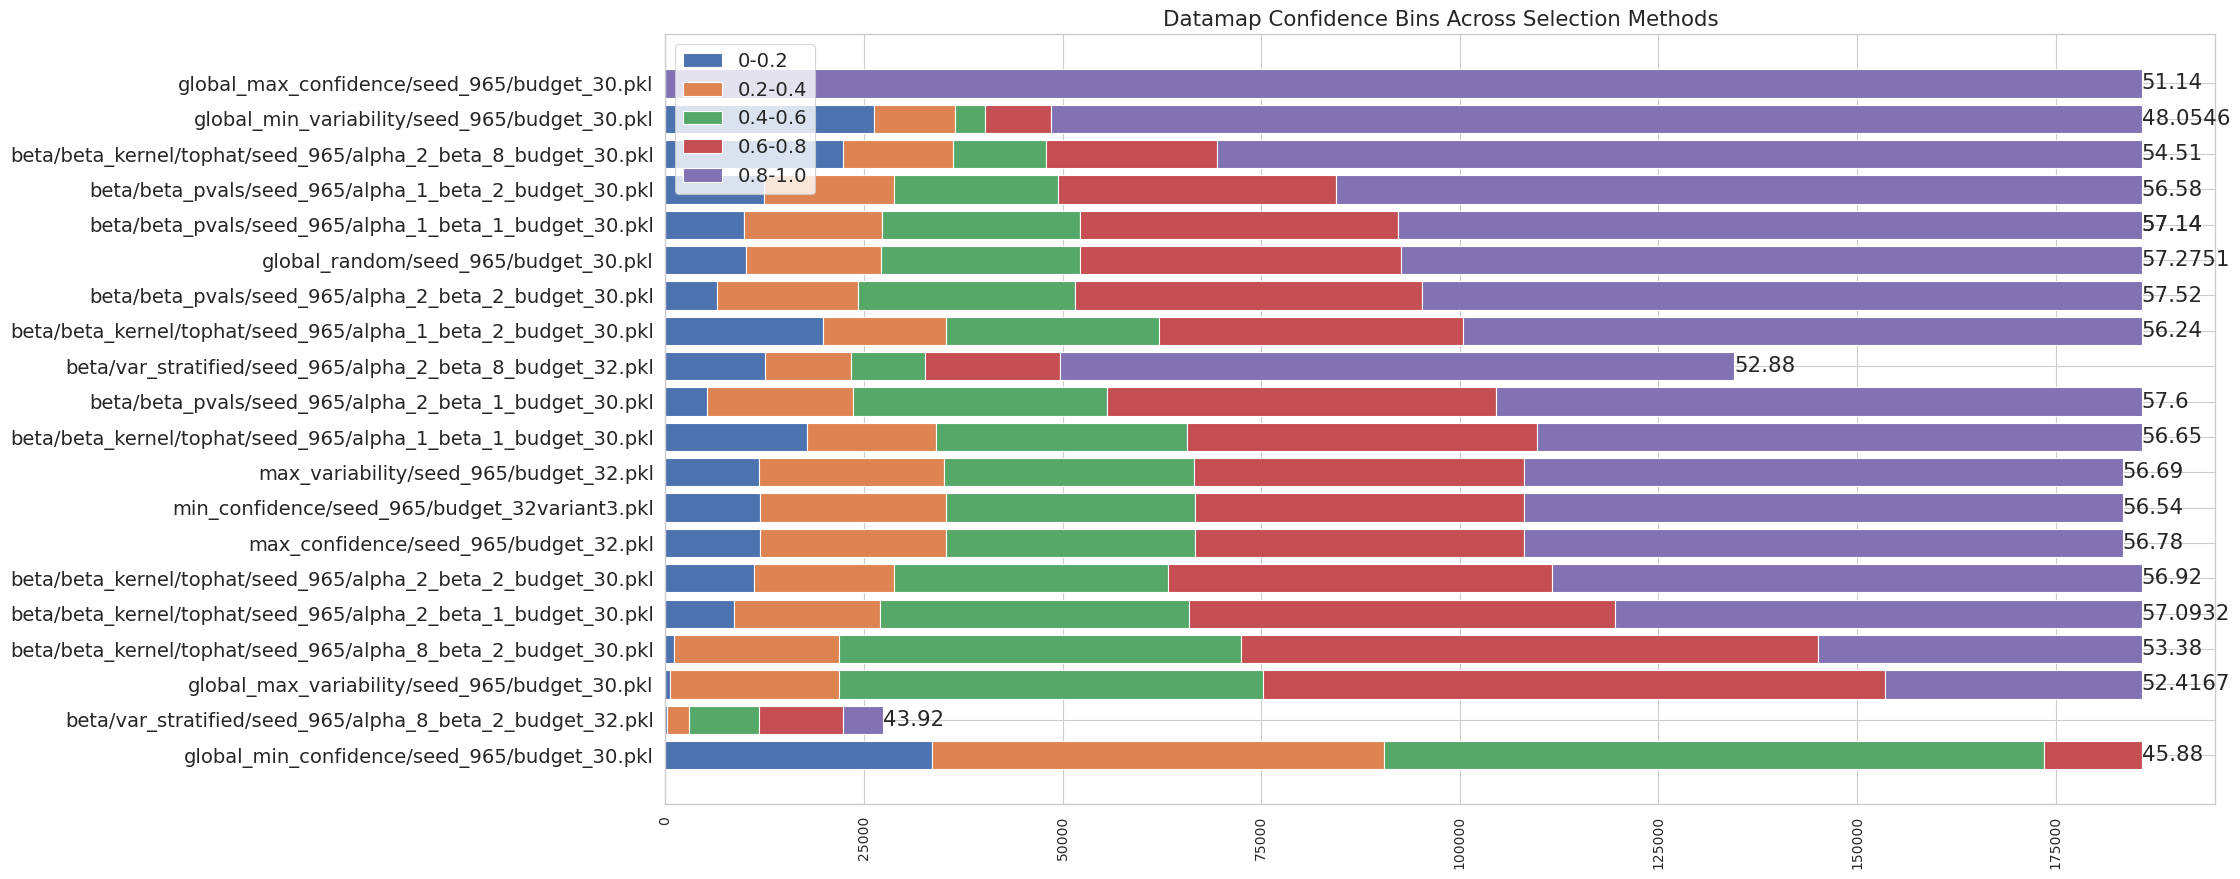

In [5]:
accuracies= [57.0932, 56.92, 56.65, 56.24, 54.51, 53.38, 57.14, 57.2751, 51.14, 45.88, 52.4167, 48.0546, 56.78, 56.69, 56.54, 52.88, 43.92, 57.6, 57.52, 57.14, 56.58]
plot_stacked_confidence(base_path, sampling_base, sampling_ids_list, accuracies)


Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl
0-0.1:  0.2676785772450409
0.1-0.2:  0.18036037673389113
0.2-0.3:  0.3739194637951452
0.3-0.4:  0.8660333937227636
0.4-0.5:  1.0
Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl
0-0.1:  0.35933682941923717
0.1-0.2:  0.20861866403567417
0.2-0.3:  0.33168566045153586
0.3-0.4:  0.7307447485677913
0.4-0.5:  1.0
Path:  beta/beta_kernel/tophat/seed_965/alpha_1_beta_1_budget_30.pkl
0-0.1:  0.5495423601837074
0.1-0.2:  0.2066811198161767
0.2-0.3:  0.2850170440652613
0.3-0.4:  0.6977427410272732
0.4-0.5:  1.0
Path:  beta/beta_kernel/tophat/seed_965/alpha_1_beta_2_budget_30.pkl
0-0.1:  0.63274811895378
0.1-0.2:  0.23821408403164981
0.2-0.3:  0.24807625001797898
0.3-0.4:  0.5234294667776527
0.4-0.5:  1.0
Path:  beta/beta_kernel/tophat/seed_965/alpha_2_beta_8_budget_30.pkl
0-0.1:  0.8266505977004006
0.1-0.2:  0.3562192897618476
0.2-0.3:  0.11443735407067894
0.3-0.4:  0.03488713705136366
0.4-0.5:  0.01354401805

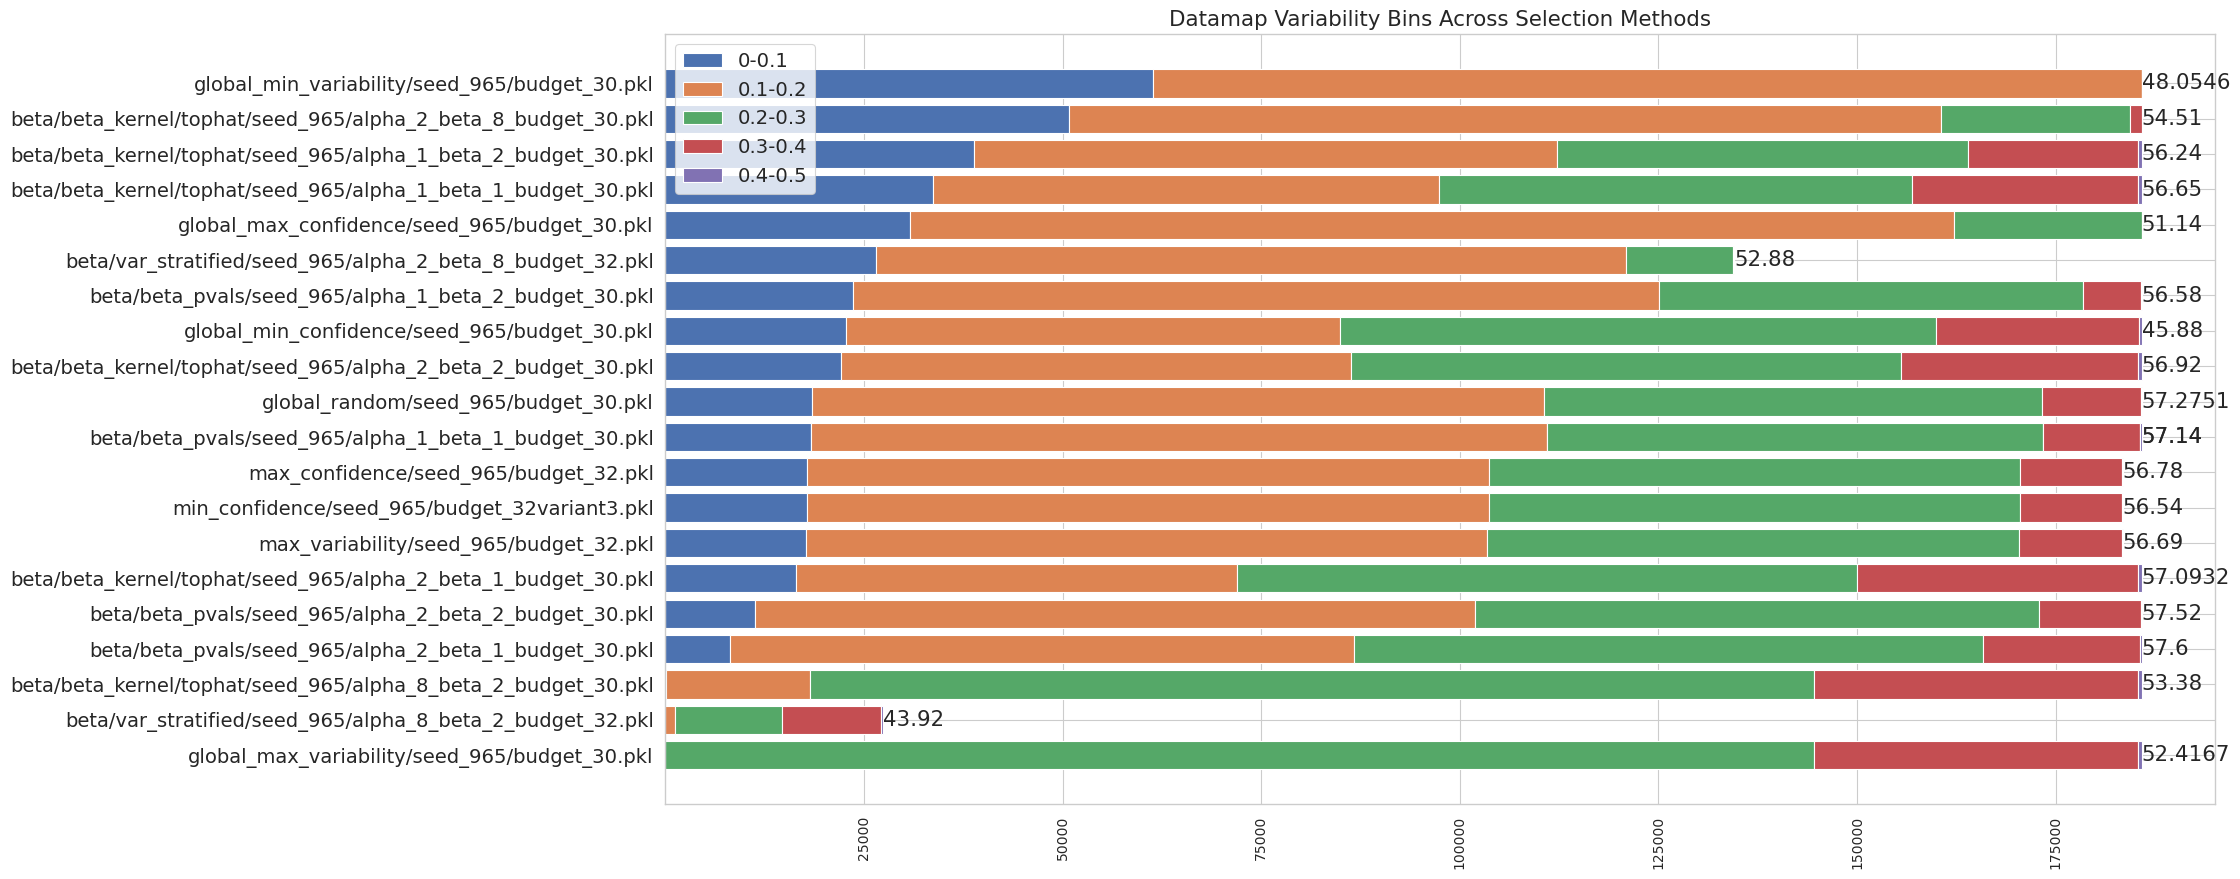

In [6]:
plot_stacked_variability(base_path, sampling_base, sampling_ids_list, accuracies)


In [ ]:
confidence = df['confidence'].tolist()
variability = df['variability'].tolist()

assert(len(confidence) == len(variability))

sampling_base = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/'
#sampling_path = 'beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl'
sampling_path = 'beta/beta_pvals/seed_965/alpha_1_beta_2_budget_30.pkl'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

with open(sampling_base + sampling_path, 'rb') as f:
    sampled_ids = pickle.load(f)

df_sampled = df.loc[df['question_id'].isin(sampled_ids)]
plt.hist(df_sampled['variability'].tolist(), bins=20)
plt.hist(df_sampled['confidence'].tolist(), bins=20)

sampling_base = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/'
sampling_path = 'global_random/seed_965/budget_30.pkl'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

with open(sampling_base + sampling_path, 'rb') as f:
    sampled_ids = pickle.load(f)

df_sampled = df.loc[df['question_id'].isin(sampled_ids)]
plt.hist(df_sampled['variability'].tolist(), bins=5)

# Class Distribution Analysis

In [2]:

def CountFrequency(my_list):
 
    # Creating an empty dictionary
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq
# also calculate skew metrics comparing random and beta sampling class distributions 




base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
sampling_base = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/'
sampling_ids_list = ['max_confidence/seed_965/budget_30.pkl', 'global_random/seed_965/budget_30.pkl']
sampling_base = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/'

targets = df['Target'].tolist()
targets = [i[0] for i in targets]
df['Target'] = targets
# targets_list = np.array(df['Target'].tolist())


# targets_multilabel =[] # unique targets in vqa dataset 
# for i in targets_list:
#     target_list = [x.strip() for x in i.split(',')]
#     targets_multilabel.extend(target_list)


with open(sampling_base + sampling_ids_list[0], 'rb') as f:
    sampled_ids = pickle.load(f)

df_sampled = df.loc[df['question_id'].isin(sampled_ids)]

targets_list = np.array(df_sampled['Target'].tolist())
targets_multilabel_beta =[] # unique targets in vqa dataset 
for i in targets_list:
    target_list = [x.strip() for x in i.split(',')]
    targets_multilabel_beta.extend(target_list)

targets_freq_beta = CountFrequency(targets_multilabel_beta)
targets_freq_beta['1 4'] = 0
targets_freq_beta['5 star'] = 0


In [3]:
with open(sampling_base + sampling_ids_list[1], 'rb') as f:
    sampled_ids = pickle.load(f)

df_sampled = df.loc[df['question_id'].isin(sampled_ids)]

targets_list = np.array(df_sampled['Target'].tolist())
targets_multilabel_random =[] # unique targets in vqa dataset 
for i in targets_list:
    target_list = [x.strip() for x in i.split(',')]
    targets_multilabel_random.extend(target_list)

targets_freq_random = CountFrequency(targets_multilabel_random)

In [4]:
targets_freq_beta_ordered = dict(sorted(targets_freq_beta.items(), key=lambda item: item[1], reverse=True))

In [5]:
targets_freq_random_ordered = {}

for key in targets_freq_beta_ordered:
    targets_freq_random_ordered[key] = targets_freq_random[key]

In [9]:
data = {'random': list(targets_freq_random_ordered.values())[:40], 
        'classwise max conf.': list(targets_freq_beta_ordered.values())[:40]}

cols = list(targets_freq_beta_ordered.keys())[:40]

comp = pd.DataFrame.from_dict(data, orient='index', columns=cols)



In [7]:
comp

,yes,no,2,1,3,white,4,0,black,5,brown,nothing,blue,red,6,gray,green,7,unknown,8,10,yellow,left,many,orange,right,tan,12,9,20,food,wood,not sure,water,grass,man,outside,15,lot,black and white
random,53167,52004,9264,8646,6047,6159,4747,4087,4131,3198,3506,2606,3824,3662,2476,2784,2947,1721,1811,1655,1558,2246,1564,1034,1608,1451,1183,983,1029,809,906,1151,903,937,923,983,768,733,627,882
beta,43418,36315,9905,7779,7507,6814,5788,4559,4447,4146,3915,3835,3824,3775,3335,2923,2772,2759,2717,2528,2511,2211,2030,1942,1873,1781,1683,1606,1512,1470,1382,1371,1362,1306,1255,1234,1190,1185,1137,1122


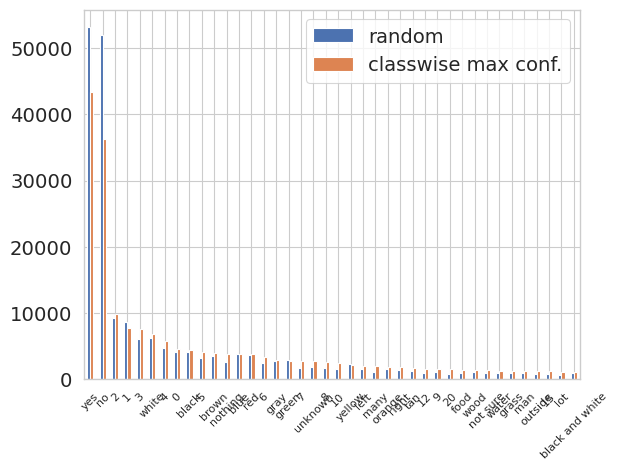

In [12]:
ax = comp.T.plot.bar(rot=0)
plt.xticks(fontsize=8, rotation=45)
plt.show()

In [43]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(comp.iloc[:,1:].values)
  
print('The Chi-Square value is {:.3f}.\nDegree of freedom is {}.\nExpected table value is \n {}'.format(stat,dof,expected))

The Chi-Square value is 20690.915.
Degree of freedom is 3126.
Expected table value is 
 [[2.31951182e+03 2.98251221e+03 2.96865847e+01 ... 2.96865847e+00
  4.94776412e-01 4.94776412e-01]
 [2.36848818e+03 3.04548779e+03 3.03134153e+01 ... 3.03134153e+00
  5.05223588e-01 5.05223588e-01]]


In [46]:
print(f"chi2 statistic:     {stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)

chi2 statistic:     20691
p-value:            0
degrees of freedom: 3126
expected frequencies:
[[2.31951182e+03 2.98251221e+03 2.96865847e+01 ... 2.96865847e+00
  4.94776412e-01 4.94776412e-01]
 [2.36848818e+03 3.04548779e+03 3.03134153e+01 ... 3.03134153e+00
  5.05223588e-01 5.05223588e-01]]


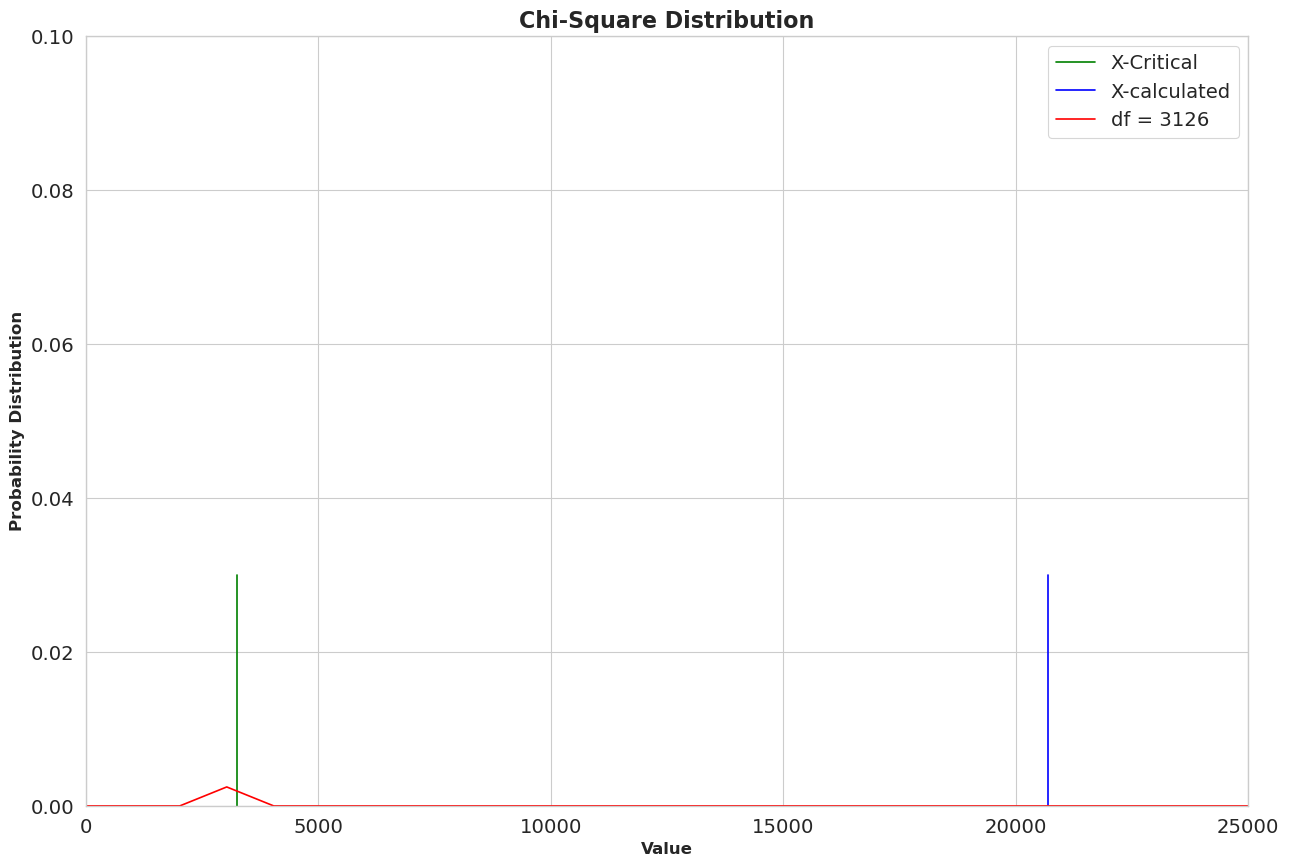

In [56]:

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 100000, 100)


fig,ax = plt.subplots(1,1, figsize=(15,10))

#plotting vertical line for critical value 
plt.axvline(x=stats.chi2.isf(0.05,dof), ymin=0, ymax= 0.3,label='X-Critical',color='green')

#plotting vertical line for calculated value. 
plt.axvline(x=stat, ymin=0, ymax= 0.3,label='X-calculated',color='blue')

#plotting distribution graph for our calculated degrees of freedom
ax.plot(x, stats.chi2.pdf(x, dof), label='df = '+ str(dof), color='red')

ax.set_xlabel('Value',fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Distribution',fontsize=12,fontweight='bold')
ax.set_title('Chi-Square Distribution',fontsize=16,fontweight='bold')

plt.xlim(0, 25000)
plt.ylim(0, 0.1)


plt.legend()
plt.show()